In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.optimize import differential_evolution

In [2]:
def ackley(x):
    '''
    the period of local minimum along each axis is 1, integer coordinate (1,1), (2,3)... 
    x and y is interchangeable
    global minimum is 0 with arguments x=y=0
    local minimums far away from orgin are 20
    supremum is 20 + e - 1/e = 22.35
    being symmetric along x=0, y=0, y=x lines
    '''
    global arg1, arg2
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

def derivative_ackley(x):
    global arg1, arg2
    return np.array([-0.4 * x[0] / arg1 * np.exp(arg1) + np.pi * np.sin(2 * np.pi * x[0]) * np.exp(arg2), 
            -0.4 * x[1] / arg1 * np.exp(arg1) + np.pi * np.sin(2 * np.pi * x[1]) * np.exp(arg2)])

In [3]:
def cma_es_general(mean0, D, alpha, beta, adjust):
    '''
    @param mean0: initial mean of groups of points
    @param D: sqrt of eigenvalues of initial variance of points
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return snapshot_val: snapshot of func values of points every 2 iterations
    @return snapshot_arg: snapshot of positions of points every 2 iterations
    '''
    # initial mean and variance
    #mean = np.random.rand(dim, 1) * 20
    #D = np.ones((dim,))              
    
    # --------------------  Initialization --------------------------------  
    # User defined input parameters (need to be edited)
    dim = 2
    mean = mean0
    sigma = 0.3
    tolerance = 1e-5
    max_iter = 500
    
    # Strategy parameter setting: Selection  
    lambda_ = 4 + int(3 * np.log(dim))       # the size of solutions group
    mu = int(lambda_ / 2)     # only best "mu" solutions are used to generate iterations
    weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
    weights = weights / np.sum(weights)      # used to combine best "mu" solutions
    mueff = np.sum(weights)**2 / np.sum(weights**2) 
    
    # Strategy parameter setting: Adaptation
    cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  # time constant for cumulation for C
    cs = (mueff + 2) / (dim + mueff + 5)  # t-const for cumulation for sigma control
    c1 = 2 / ((dim + 1.3)**2 + mueff)    # learning rate for rank-one update of C
    cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  # and for rank-mu update
    damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs  # damping for sigma, usually close to 1                                                                 
        
    # Initialize dynamic (internal) strategy parameters and constants
    pc = np.zeros((dim, 1))     # evolution paths for C and sigma
    ps = np.zeros((dim, 1)) 
    B = np.eye(dim)     # B defines the coordinate system
    C = B * np.diag(D**2) * B.T            # covariance matrix C
    invsqrtC = B * np.diag(D**-1) * B.T    # C^-1/2 
    chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  # expectation of ||N(0,I)|| == norm(randn(N,1)) 
    
    def update_mean(x):
        return (weights @ x).reshape(dim, 1)
    def update_ps(ps, sigma, C, mean, mean_old):
        return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
    def update_pc(pc, sigma, ps, mean, mean_old):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
    def update_C(C, pc, x, mean_old, sigma):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
        return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
    def update_sigma(sigma, ps):
        return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
    
    x = np.zeros((lambda_, dim))
    f = np.zeros((lambda_,))
    snapshot_arg = []
    snapshot_val = []
    fmin = []
    iter_ = 0
    eval_ = 0
    while iter_ < max_iter:
        iter_ += 1
        # generate candidate solutions with some stochastic elements
        for i in range(lambda_):
            x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
            x[i], eval_cnt = adjust(x[i], alpha, beta)
            f[i] = ackley(x[i])
            eval_ += eval_cnt
            
        # sort the value and positions of solutions 
        idx = np.argsort(f)
        x_ascending = x[idx]
        
        # record the trail and value of solutions points
        snapshot_arg.append(x_ascending)
        snapshot_val.append(f[idx])
        
        # update the parameter for next iteration
        mean_old = mean
        mean = update_mean(x_ascending[:mu])
        ps =   update_ps(ps, sigma, C, mean, mean_old)
        pc =   update_pc(pc, sigma, ps, mean, mean_old)
        sigma = update_sigma(sigma, ps)
        C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
        C = np.triu(C) + np.triu(C, 1).T
        D, B = np.linalg.eig(C)
        D = np.sqrt(D)
        invsqrtC = B @ np.diag(D**-1) @ B
        # check the stop condition
        # f[0] < tolerance 
        if np.linalg.norm(f) < tolerance or (np.max(D) > (np.min(D) * 1e7)):  #np.abs(f[0] - fmin_old) < tolerance:
            break
            
    # analyse the result after finish
    if f[0] > tolerance:
        print('stuck in local minimum!!')
        print('iterations = {}, eigenvalue = {}'.format(iter_, D))
    else:
        print('Global minimum')
    print('min = {}, total iterations = {}, total evaluatios = {}\n position = {} {}'.format(f[0], iter_, eval_, x_ascending[0, 0], x_ascending[0, 1]))
    return np.array(snapshot_val), np.array(snapshot_arg)

def line_search(x0, alpha, beta):
    '''
    @param x0: initial point position
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return x: point position after moving to local minimum
    '''
    x = x0.copy()
    alpha0 = alpha
    beta = 0.1
    tao = 0.5
    k_max = 100
    f = ackley
    deri_f = derivative_ackley
    fx = f(x)
    p = - deri_f(x)
    fnx = f(x + alpha * p)
    evaluation_cnt = 4
    for k in range(k_max):
        while fnx > fx + alpha * beta * (-p @ p):
            alpha *= tao
            fnx = f(x + alpha * p)
            evaluation_cnt += 1
        x += alpha * p
        fx = fnx
        p = -deri_f(x)
        fnx = f(x + alpha * p)
        evaluation_cnt += 2
        if np.linalg.norm(p) < 1e-5:
            break
    return x, evaluation_cnt

def do_nothing(x0, alpha, beta):
    return x0, 1

In [28]:
np.random.seed(34)
mean0 = np.array([[140.743], [152.21]])
D = np.ones((2,)) * 10
alpha = 1
beta = 2

%time val, arg = cma_es_general(mean0, D, alpha, beta, line_search)

Global minimum
min = 4.440892098500626e-16, total iterations = 37, total evaluatios = 22460
 position = 1.0529642920474356e-16 1.179580288606663e-16
CPU times: user 341 ms, sys: 2.43 ms, total: 343 ms
Wall time: 343 ms


In [30]:
%time val, arg = cma_es_general(mean0, D, alpha, beta, do_nothing)

stuck in local minimum!!
iterations = 500, eigenvalue = [5.04114563e-09 1.58574395e-08]
min = 19.999999999994593, total iterations = 500, total evaluatios = 3000
 position = 137.00000000451357 152.00000000657664
CPU times: user 180 ms, sys: 2.81 ms, total: 183 ms
Wall time: 185 ms


In [32]:
def plot_distance(arg, val):
    distance_arg = np.linalg.norm(arg, axis=(1,2))
    distance_val = np.linalg.norm(val, axis=1)
    fig = plt.figure(figsize=(10, 5))
    ax1=fig.add_subplot(1, 1, 1)
    ax1.plot(np.arange(val.shape[0]), distance_arg, color='green', label='Frobenius norm \nof parameters')
    ax1.set_xlabel('iteration', fontsize=15)
    ax1.set_ylabel('distance in domain', color='green', fontsize=15)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='center left')

    ax2 = ax1.twinx()  
    ax2.plot(np.arange(val.shape[0]), distance_val, color='red', label='L2 norm \nof func value')
    ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='center right')

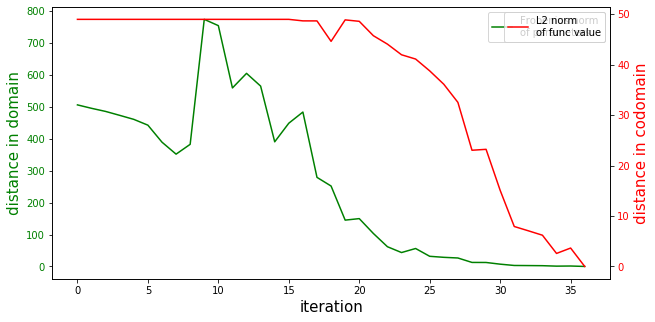

In [29]:
plot_distance(arg,val)

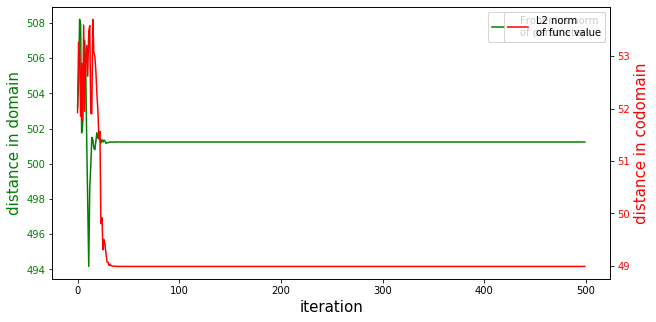

In [31]:
plot_distance(arg,val)

In [33]:
val[-3:]

array([[20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20.]])

In [34]:
arg[-3:]

array([[[137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.        ],
        [137.        , 152.00000001],
        [137.        , 152.00000001]],

       [[137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001]],

       [[137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001],
        [137.        , 152.00000001]]])